# Setup

In [2]:
import os 
from google.colab import drive
import sys


#need this to load vizdoom module 
system_path = '/content/drive/MyDrive/GitHub/INM363-Project'
drive.mount('/content/drive')
sys.path.append(system_path)

system_path = '/content/drive/MyDrive/GitHub/INM363-Project/src' 
sys.path.append(system_path)

#need this to use gpu on ray 
os.environ['PYTHONPATH'] = '/content/drive/MyDrive/GitHub/INM363-Project' 
os.environ['PYTHONPATH']

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'/content/drive/MyDrive/GitHub/INM363-Project'

In [3]:
%%bash
# Install deps from 
# https://github.com/mwydmuch/ViZDoom/blob/master/doc/Building.md#-linux

apt-get update &> /dev/null


apt-get install build-essential zlib1g-dev libsdl2-dev libjpeg-dev \
nasm tar libbz2-dev libgtk2.0-dev cmake git libfluidsynth-dev libgme-dev \
libopenal-dev timidity libwildmidi-dev unzip &> /dev/null

# Boost libraries
apt-get install libboost-all-dev &> /dev/null


In [4]:
!pip install vizdoom --quiet 
!pip install ray  --quiet
!pip install ray['rllib'] --quiet
!pip install Ipython --upgrade --quiet

In [5]:
from src.vizdoom_gym.envs.VizDoomEnv import VizdoomEnv
from src.vizdoom_gym.envs.VizDoomEnv_def import VizDoomVeryDenseReward

In [6]:
from ray.tune.registry import register_env
import gym
import os
import ray
import ray.rllib.agents.ppo as ppo
from ray.rllib.algorithms.callbacks import RE3UpdateCallbacks
import shutil
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math 
from fnmatch import fnmatch 
import numpy as np
import src.helper_fuctions as helper
sns.set()

/usr/local/lib/python3.7/dist-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device: ", device, "\n")

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

device:  cuda:0 

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


/usr/local/lib/python3.7/dist-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Initialize Ray

In [34]:
ray.shutdown()
print("Shutdown ray")
# start Ray -- add `local_mode=True` here for debugging
ray.init(ignore_reinit_error=True,  num_cpus =2, num_gpus = 1) #local_mode=True,

print("Initialized ray")

# register the custom environment
select_env = "VizDoomVeryDenseReward-v0"

register_env(select_env, lambda config: VizDoomVeryDenseReward())

print("registered environment")

Shutdown ray


2022-09-27 13:51:32,121	INFO worker.py:1518 -- Started a local Ray instance.


Initialized ray
registered environment


# PPO

In [9]:
# configure the environment and create agent
config = ppo.DEFAULT_CONFIG.copy()
config["log_level"] = "WARN"
config["num_workers"] = 1
config["framework"] = "torch"
config["model"] = {"dim": 42, 
                   "grayscale": True,
                   }
config["num_gpus"] = 1
config["preprocessor_pref"] = "rllib"
config['batch_mode'] = 'complete_episodes'

#changing this for evaluation time 
config['explore'] = False 
config['in_evaluation'] = True

ppo_agent = ppo.PPOTrainer(config, env=select_env)

print("created agent")

2022-09-27 13:34:45,938	INFO ppo.py:379 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
2022-09-27 13:34:45,950	INFO algorithm.py:354 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
/usr/local/lib/python3.7/dist-packages/ray/_private/ray_option_utils.py:273: DeprecationWarning: Setting 'object_store_memory' for actors is deprecated since it doesn't actually reserve the required object store memory. Use object spilling that's enabled by default (https://docs.ray.io/en/releases-2.0.0/ray-core/objects/object-spilling.html) instead to bypass the object store memory size limitation.
  stacklevel=1,


(RolloutWorker pid=13350) config file: /content/drive/MyDrive/GitHub/INM363-Project/scenarios/custom/very_dense_reward.cfg
(RolloutWorker pid=13350) scenario file: /content/drive/MyDrive/GitHub/INM363-Project/scenarios/custom/test/new_sparse_reward_fixed_start.wad
(RolloutWorker pid=13350) episode timeout: 800
(RolloutWorker pid=13350) screen resolution: 320X240


(RolloutWorker pid=13350) 2022-09-27 13:34:58,924	WARNING env.py:143 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.
2022-09-27 13:35:07,015	INFO trainable.py:164 -- Trainable.setup took 21.083 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2022-09-27 13:35:07,020	WARNING util.py:65 -- Install gputil for GPU system monitoring.


created agent


In [10]:
#create environment 
env = gym.make('VizDoomVeryDenseReward-v0')

/usr/local/lib/python3.7/dist-packages/gym/envs/registration.py:595: UserWarning: WARN: Overriding environment VizdoomMyWayHome-v0
  logger.warn(f"Overriding environment {id}")
/usr/local/lib/python3.7/dist-packages/gym/envs/registration.py:595: UserWarning: WARN: Overriding environment VizDoomVeryDenseReward-v0
  logger.warn(f"Overriding environment {id}")


config file: /content/drive/MyDrive/GitHub/INM363-Project/scenarios/custom/very_dense_reward.cfg
scenario file: /content/drive/MyDrive/GitHub/INM363-Project/scenarios/custom/test/new_sparse_reward_fixed_start.wad
episode timeout: 800
screen resolution: 320X240


In [11]:

chkpt_root = "/content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/sparse" 

pattern = '*checkpoint*'
checkpoints = [x for x in os.listdir(chkpt_root) if fnmatch(x,pattern )]


print("Total number of checkpoints: ", len(checkpoints))


ppo_chkpt_mean_rewards = np.array([]) 
ppo_chkpt_std_rewards = np.array([]) 
ppo_chkpt_mean_steps = np.array([]) 
ppo_chkpt_std_steps = np.array([]) 


for chkpt_dir in checkpoints:
  chkpt_pth = chkpt_root + '/' + chkpt_dir 
  print(chkpt_dir)
  ppo_agent.restore(chkpt_pth)

  num_episodes = 10
  total_reward = []
  total_steps = [] 
  #chkpt_mean_reward = 0 

  for i in range(num_episodes):
    state = env.reset()
    eps_reward = 0
    eps_steps = 0 
    n_step = 200

    for step in range(n_step):
          action = ppo_agent.compute_action(state)
          state, reward, done, info = env.step(action)
          eps_reward += reward

          #if episode ends early
          if done == 1:
              total_reward.append(eps_reward)
              total_steps.append(step+1)
              state = env.reset()
              break

    #if episode timeout
    if done == 0:
      total_reward.append(eps_reward)
      total_steps.append(n_step)

  #get mean and std over all episodes
  ppo_chkpt_mean_rewards = np.append(ppo_chkpt_mean_rewards, np.mean(total_reward) )
  ppo_chkpt_std_rewards = np.append(ppo_chkpt_std_rewards, np.std(total_reward))
  ppo_chkpt_mean_steps = np.append(ppo_chkpt_mean_steps, np.mean(total_steps))
  ppo_chkpt_std_steps = np.append(ppo_chkpt_std_steps, np.std(total_steps))



2022-09-27 13:35:07,536	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/sparse/checkpoint_000001
2022-09-27 13:35:07,543	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 1, '_timesteps_total': None, '_time_total': 87.64860653877258, '_episodes_total': 21}
2022-09-27 13:35:07,549	WARNING deprecation.py:48 -- DeprecationWarning: `compute_action` has been deprecated. Use `Trainer.compute_single_action()` instead. This will raise an error in the future!


Total number of checkpoints:  41
checkpoint_000001


2022-09-27 13:35:15,247	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/sparse/checkpoint_000010
2022-09-27 13:35:15,249	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 10, '_timesteps_total': None, '_time_total': 873.1147065162659, '_episodes_total': 228}


checkpoint_000010


2022-09-27 13:35:23,402	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/sparse/checkpoint_000020
2022-09-27 13:35:23,409	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 20, '_timesteps_total': None, '_time_total': 1738.2956686019897, '_episodes_total': 459}


checkpoint_000020


2022-09-27 13:35:31,080	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/sparse/checkpoint_000030
2022-09-27 13:35:31,084	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 30, '_timesteps_total': None, '_time_total': 2604.87304520607, '_episodes_total': 695}


checkpoint_000030


2022-09-27 13:35:38,549	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/sparse/checkpoint_000040
2022-09-27 13:35:38,551	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 40, '_timesteps_total': None, '_time_total': 3461.435373544693, '_episodes_total': 942}


checkpoint_000040


2022-09-27 13:35:46,302	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/sparse/checkpoint_000050
2022-09-27 13:35:46,304	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 50, '_timesteps_total': None, '_time_total': 4321.420607805252, '_episodes_total': 1194}


checkpoint_000050


2022-09-27 13:35:54,022	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/sparse/checkpoint_000060
2022-09-27 13:35:54,025	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 60, '_timesteps_total': None, '_time_total': 5180.14714717865, '_episodes_total': 1450}


checkpoint_000060


2022-09-27 13:36:01,662	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/sparse/checkpoint_000070
2022-09-27 13:36:01,671	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 70, '_timesteps_total': None, '_time_total': 6041.6440052986145, '_episodes_total': 1697}


checkpoint_000070


2022-09-27 13:36:09,290	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/sparse/checkpoint_000080
2022-09-27 13:36:09,299	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 80, '_timesteps_total': None, '_time_total': 6897.731177568436, '_episodes_total': 1935}


checkpoint_000080


2022-09-27 13:36:16,895	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/sparse/checkpoint_000090
2022-09-27 13:36:16,904	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 90, '_timesteps_total': None, '_time_total': 7759.514708042145, '_episodes_total': 2179}


checkpoint_000090


2022-09-27 13:36:24,663	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/sparse/checkpoint_000100
2022-09-27 13:36:24,665	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 100, '_timesteps_total': None, '_time_total': 8617.18613409996, '_episodes_total': 2433}


checkpoint_000100


2022-09-27 13:36:32,195	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/sparse/checkpoint_000110
2022-09-27 13:36:32,197	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 110, '_timesteps_total': None, '_time_total': 9471.747158050537, '_episodes_total': 2681}


checkpoint_000110


2022-09-27 13:36:39,775	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/sparse/checkpoint_000120
2022-09-27 13:36:39,782	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 120, '_timesteps_total': None, '_time_total': 10318.40287733078, '_episodes_total': 2932}


checkpoint_000120


2022-09-27 13:36:47,462	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/sparse/checkpoint_000130
2022-09-27 13:36:47,471	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 130, '_timesteps_total': None, '_time_total': 11173.80902004242, '_episodes_total': 3179}


checkpoint_000130


2022-09-27 13:36:55,596	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/sparse/checkpoint_000140
2022-09-27 13:36:55,601	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 140, '_timesteps_total': None, '_time_total': 12020.09320116043, '_episodes_total': 3437}


checkpoint_000140


2022-09-27 13:37:03,143	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/sparse/checkpoint_000150
2022-09-27 13:37:03,145	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 150, '_timesteps_total': None, '_time_total': 12872.360900878906, '_episodes_total': 3684}


checkpoint_000150


2022-09-27 13:37:10,682	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/sparse/checkpoint_000160
2022-09-27 13:37:10,686	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 160, '_timesteps_total': None, '_time_total': 13727.893499135971, '_episodes_total': 3935}


checkpoint_000160


2022-09-27 13:37:18,237	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/sparse/checkpoint_000170
2022-09-27 13:37:18,239	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 170, '_timesteps_total': None, '_time_total': 14574.476639270782, '_episodes_total': 4197}


checkpoint_000170


2022-09-27 13:37:25,912	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/sparse/checkpoint_000180
2022-09-27 13:37:25,915	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 180, '_timesteps_total': None, '_time_total': 15432.58521938324, '_episodes_total': 4455}


checkpoint_000180


2022-09-27 13:37:33,526	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/sparse/checkpoint_000190
2022-09-27 13:37:33,529	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 190, '_timesteps_total': None, '_time_total': 16283.362129688263, '_episodes_total': 4713}


checkpoint_000190


2022-09-27 13:37:41,161	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/sparse/checkpoint_000200
2022-09-27 13:37:41,164	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 200, '_timesteps_total': None, '_time_total': 17135.15302848816, '_episodes_total': 4984}


checkpoint_000200


2022-09-27 13:37:48,768	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/sparse/checkpoint_000220
2022-09-27 13:37:48,771	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 220, '_timesteps_total': None, '_time_total': 18917.746857643127, '_episodes_total': 5547}


checkpoint_000220


2022-09-27 13:37:56,322	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/sparse/checkpoint_000240
2022-09-27 13:37:56,327	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 240, '_timesteps_total': None, '_time_total': 20650.390123844147, '_episodes_total': 6163}


checkpoint_000240


2022-09-27 13:38:03,907	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/sparse/checkpoint_000260
2022-09-27 13:38:03,908	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 260, '_timesteps_total': None, '_time_total': 22359.07574248314, '_episodes_total': 6964}


checkpoint_000260


2022-09-27 13:38:11,266	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/sparse/checkpoint_000280
2022-09-27 13:38:11,268	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 280, '_timesteps_total': None, '_time_total': 24079.547958612442, '_episodes_total': 7936}


checkpoint_000280


2022-09-27 13:38:13,755	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/sparse/checkpoint_000300
2022-09-27 13:38:13,757	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 300, '_timesteps_total': None, '_time_total': 25816.969799518585, '_episodes_total': 9179}


checkpoint_000300


2022-09-27 13:38:16,253	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/sparse/checkpoint_000320
2022-09-27 13:38:16,256	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 320, '_timesteps_total': None, '_time_total': 27536.33552455902, '_episodes_total': 10547}


checkpoint_000320


2022-09-27 13:38:18,531	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/sparse/checkpoint_000340
2022-09-27 13:38:18,536	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 340, '_timesteps_total': None, '_time_total': 29268.767613887787, '_episodes_total': 11926}


checkpoint_000340


2022-09-27 13:38:20,827	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/sparse/checkpoint_000360
2022-09-27 13:38:20,831	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 360, '_timesteps_total': None, '_time_total': 30996.26118326187, '_episodes_total': 13301}


checkpoint_000360


2022-09-27 13:38:23,286	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/sparse/checkpoint_000380
2022-09-27 13:38:23,292	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 380, '_timesteps_total': None, '_time_total': 32735.68697452545, '_episodes_total': 14685}


checkpoint_000380


2022-09-27 13:38:25,681	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/sparse/checkpoint_000400
2022-09-27 13:38:25,683	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 400, '_timesteps_total': None, '_time_total': 34490.9748005867, '_episodes_total': 16042}


checkpoint_000400


2022-09-27 13:38:27,966	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/sparse/checkpoint_000420
2022-09-27 13:38:27,972	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 420, '_timesteps_total': None, '_time_total': 36222.239555597305, '_episodes_total': 17435}


checkpoint_000420


2022-09-27 13:38:30,451	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/sparse/checkpoint_000440
2022-09-27 13:38:30,454	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 440, '_timesteps_total': None, '_time_total': 37951.662880182266, '_episodes_total': 18860}


checkpoint_000440


2022-09-27 13:38:32,879	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/sparse/checkpoint_000460
2022-09-27 13:38:32,881	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 460, '_timesteps_total': None, '_time_total': 39689.95190167427, '_episodes_total': 20271}


checkpoint_000460


2022-09-27 13:38:35,338	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/sparse/checkpoint_000480
2022-09-27 13:38:35,341	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 480, '_timesteps_total': None, '_time_total': 41411.52815961838, '_episodes_total': 21735}


checkpoint_000480


2022-09-27 13:38:38,247	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/sparse/checkpoint_000500
2022-09-27 13:38:38,250	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 500, '_timesteps_total': None, '_time_total': 43138.66213440895, '_episodes_total': 23118}


checkpoint_000500


2022-09-27 13:38:40,769	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/sparse/checkpoint_000520
2022-09-27 13:38:40,772	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 520, '_timesteps_total': None, '_time_total': 44865.585448503494, '_episodes_total': 24536}


checkpoint_000520


2022-09-27 13:38:43,009	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/sparse/checkpoint_000540
2022-09-27 13:38:43,016	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 540, '_timesteps_total': None, '_time_total': 46587.654601573944, '_episodes_total': 25946}


checkpoint_000540


2022-09-27 13:38:45,595	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/sparse/checkpoint_000560
2022-09-27 13:38:45,597	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 560, '_timesteps_total': None, '_time_total': 48308.888113737106, '_episodes_total': 27350}


checkpoint_000560


2022-09-27 13:38:48,229	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/sparse/checkpoint_000580
2022-09-27 13:38:48,231	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 580, '_timesteps_total': None, '_time_total': 50042.58826875687, '_episodes_total': 28713}


checkpoint_000580


2022-09-27 13:38:50,767	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/sparse/checkpoint_000600
2022-09-27 13:38:50,770	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 600, '_timesteps_total': None, '_time_total': 51806.74436926842, '_episodes_total': 30150}


checkpoint_000600


In [12]:
#read first results file 
results_pth = chkpt_root + '/' + 'result.csv'
ppo_df = pd.read_csv(results_pth) 
ppo_df['eps_cumsum'] = ppo_df['episodes_this_iter'].cumsum()
ppo_df = ppo_df[['checkpoint', 'eps_cumsum']]
ppo_df.checkpoint = ppo_df['checkpoint'].astype(int)
ppo_df.tail()

ppo_cum_eps = [] 
for chkpt in checkpoints:
  chkpt_int = int(chkpt.split('_')[-1])
  eps_num = ppo_df[~(ppo_df['eps_cumsum'].where(ppo_df['checkpoint'] == chkpt_int)).isna()].eps_cumsum.values[0]
  ppo_cum_eps.append(eps_num)


In [13]:
print(f"Total episodes: {ppo_cum_eps}")
print(f"Mean reward: {ppo_chkpt_mean_rewards}")
print(f"Std reward: {ppo_chkpt_std_rewards}")
print(f"Mean steps: {ppo_chkpt_mean_steps}")
print(f"Std steps: {ppo_chkpt_std_steps}")

#check length of lists are the same 
assert len(ppo_cum_eps) == len(ppo_chkpt_mean_rewards)
assert len(ppo_cum_eps) == len(ppo_chkpt_mean_steps)

Total episodes: [21.0, 228.0, 459.0, 695.0, 942.0, 1194.0, 1450.0, 1697.0, 1935.0, 2179.0, 2433.0, 2681.0, 2932.0, 3179.0, 3437.0, 3684.0, 3935.0, 4197.0, 4455.0, 4713.0, 4984.0, 5547.0, 6163.0, 6964.0, 7936.0, 9179.0, 10547.0, 11926.0, 13301.0, 14685.0, 16042.0, 17435.0, 18860.0, 20271.0, 21735.0, 23118.0, 24536.0, 25946.0, 27350.0, 28713.0, 30150.0]
Mean reward: [ 0.  0.  0.  1.  0.  0.  1.  0.  0.  0.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  0.  1.  1.  1.  1. 13. 13. 13. 12. 12. 13. 13. 13. 13. 13. 13. 13.
 13. 13. 13. 13. 13.]
Std reward: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Mean steps: [200.  200.  200.  200.  200.  200.  200.  200.  200.  200.  200.  200.
 200.  200.  200.  200.  200.  200.  200.  200.  200.  200.  200.  200.
  63.   63.   57.   57.   60.   57.   57.   61.   61.   61.   60.   62.6
  57.   65.   66.   64.   62. ]
Std steps: [0.         0.         0.         0.         0.        

## PPO avg reward

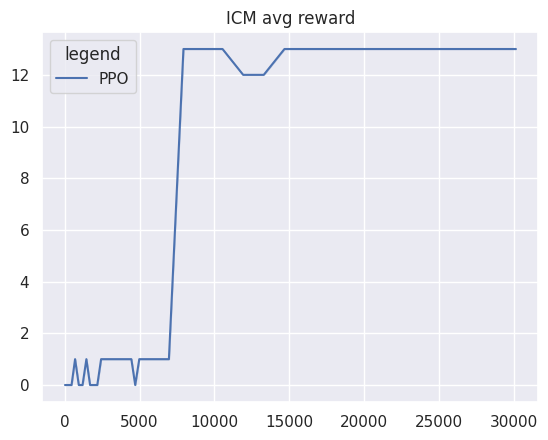

In [14]:
# https://stackoverflow.com/questions/61368805/how-to-plot-shaded-error-bands-with-seaborn

plt.plot(ppo_cum_eps, ppo_chkpt_mean_rewards, 'b-', label='PPO')
plt.fill_between(ppo_cum_eps, ppo_chkpt_mean_rewards - ppo_chkpt_std_rewards, ppo_chkpt_mean_rewards + ppo_chkpt_std_rewards, color='b', alpha=0.2) 


plt.legend(title='legend')
plt.title("ICM avg reward") 
plt.show()


## PPO avg steps

/usr/local/lib/python3.7/dist-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


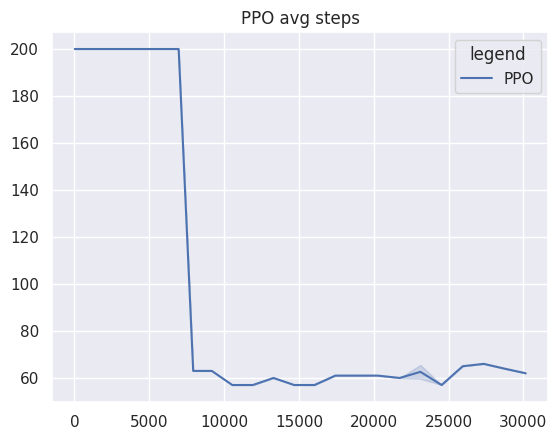

In [15]:
# https://stackoverflow.com/questions/61368805/how-to-plot-shaded-error-bands-with-seaborn

plt.plot(ppo_cum_eps, ppo_chkpt_mean_steps, 'b-', label='PPO')
plt.fill_between(ppo_cum_eps, (ppo_chkpt_mean_steps - ppo_chkpt_std_steps), (ppo_chkpt_mean_steps + ppo_chkpt_std_steps), color='b', alpha=0.2) 

plt.legend(title='legend')
plt.title("PPO avg steps") 
plt.show()


## PPO Path

In [16]:
#max_mean_rewards_idx = np.argmax(ppo_chkpt_mean_rewards)
max_mean_rewards_idx = np.argmin(ppo_chkpt_mean_steps)
eps_itr = ppo_cum_eps[max_mean_rewards_idx]
print(eps_itr)
best_chkpt = ppo_df[~(ppo_df["eps_cumsum"].where(ppo_df['eps_cumsum'] == eps_itr)).isna()]['checkpoint'].values[0]
print("Best checkpoint: ", best_chkpt)

10547.0
Best checkpoint:  320


/usr/local/lib/python3.7/dist-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [17]:
chkpt_root = "/content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/sparse" 
chkpt_dir = "checkpoint_000" + str(best_chkpt)
chkpt_pth = chkpt_root + "/" + chkpt_dir
print(chkpt_pth)
ppo_agent.restore(chkpt_pth)

2022-09-27 13:38:53,885	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/sparse/checkpoint_000320
2022-09-27 13:38:53,887	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 320, '_timesteps_total': None, '_time_total': 27536.33552455902, '_episodes_total': 10547}


/content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/sparse/checkpoint_000320


cumulative reward 13.0
total steps: 56
Config file path: /content/drive/MyDrive/GitHub/INM363-Project/scenarios/custom/very_dense_reward.cfg
Scenario path: /content/drive/MyDrive/GitHub/INM363-Project/scenarios/custom/train/new_sparse_rs.wad
Health Bonus locations: [(-544.0, 96.0), (-544.0, 352.0), (-800.0, 96.0)]
Armor location: [(-544.0, -160.0)]
Sector locations: [(-640.0, -704.0, 32.0, 32.0), (-704.0, -640.0, 160.0, 160.0), (-608.0, -608.0, 192.0, 256.0), (-480.0, -480.0, 256.0, 192.0), (-640.0, -640.0, -256.0, -64.0), (-448.0, -640.0, -256.0, -256.0), (-448.0, -448.0, -64.0, -256.0), (-640.0, -608.0, -64.0, -64.0), (-480.0, -448.0, -64.0, -64.0), (-640.0, -640.0, 0.0, 32.0), (-448.0, -480.0, 0.0, 0.0), (-640.0, -640.0, 160.0, 192.0), (-608.0, -640.0, 0.0, 0.0), (-448.0, -448.0, 192.0, 0.0), (-640.0, -608.0, 192.0, 192.0), (-480.0, -448.0, 192.0, 192.0), (-480.0, -480.0, 0.0, -64.0), (-608.0, -608.0, -64.0, 0.0), (-448.0, -480.0, 256.0, 256.0), (-448.0, -448.0, 448.0, 256.0), (-640

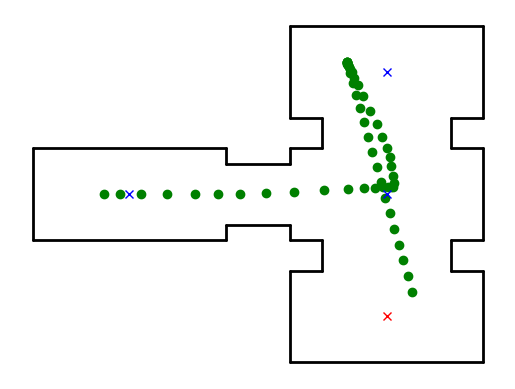

In [18]:
state = env.reset()
sum_reward = 0
n_step = 200
ppo_path = [] 

for step in range(n_step):
    action = ppo_agent.compute_action(state)
    state, reward, done, info = env.step(action)
    sum_reward += reward
    
    if len(info) > 0:
      ppo_path.append((info["X"], info["Y"]))

    #env.render()

    if done == 1:
        # report at the end of each episode
        print("cumulative reward", sum_reward)
        print(f"total steps: {step}")
        state = env.reset()
        sum_reward = 0
        break

if done == 0:
  print("cumulative reward", sum_reward)
  print(f"total steps: {step}")


sectors, health_pos, armor_pos = helper.get_env_layout(config = "custom/very_dense_reward.cfg",
                                                       scenario = "custom/train/new_sparse_rs.wad" )
helper.plot_layout(sectors, health_pos, armor_pos, ppo_path)


## PPO Goal Accomplishment 

In [19]:
state = env.reset()

#ppo_path = [] 
num_episodes = 100 
goal_reached = 0 

for i in range(num_episodes):
    state = env.reset()
    eps_reward = 0
    n_step = 200

    for step in range(n_step):
        action = ppo_agent.compute_action(state)
        state, reward, done, info = env.step(action)
        eps_reward += reward
      
        if done == 1:
          break 

    if eps_reward > 10:
        goal_reached += 1
      
    

print(f"Number of time goal reached: {goal_reached} / {num_episodes}")


Number of time goal reached: 100 / 100


# ICM 

In [20]:
# configure the environment and create agent
config = ppo.DEFAULT_CONFIG.copy()
config["log_level"] = "WARN"
#config["num_workers"] = 1
config["framework"] = "torch"
config["model"] = {"dim": 42, 
                   "grayscale": True,
                   }
config["num_gpus"] = 1
config["preprocessor_pref"] = "rllib"
config['batch_mode'] = 'complete_episodes'

#changing this for evaluation time 
config['explore'] = False
config['in_evaluation'] = True

config["num_workers"] = 0 

config["exploration_config"] = {
    "type": "Curiosity",  # <- Use the Curiosity module for exploring.
    "eta": 0.01, #0.001,  # Weight for intrinsic rewards before being added to extrinsic ones.
    "lr": 0.001,  # Learning rate of the curiosity (ICM) module.
    "feature_dim": 288,  # Dimensionality of the generated feature vectors.
    # Setup of the feature net (used to encode observations into feature (latent) vectors).
    "feature_net_config": {
        "fcnet_hiddens": [],
        "fcnet_activation": "relu",
    },
    "inverse_net_hiddens": [256],  # Hidden layers of the "inverse" model.
    "inverse_net_activation": "relu",  # Activation of the "inverse" model.
    "forward_net_hiddens": [256],  # Hidden layers of the "forward" model.
    "forward_net_activation": "relu",  # Activation of the "forward" model.
    "beta": 0.2,  # Weight for the "forward" loss (beta) over the "inverse" loss (1.0 - beta).
    # Specify, which exploration sub-type to use (usually, the algo's "default"
    # exploration, e.g. EpsilonGreedy for DQN, StochasticSampling for PG/SAC).
   
    "sub_exploration": {
#        "type": "EpsilonGreedy",
#        "initial_epsilon": 1.0, #0.01,
#        "final_epsilon": 0.01, #0.001
        "type": "StochasticSampling",
        
    }
}
config["vf_clip_param"] = 400
icm_agent = ppo.PPOTrainer(config, env=select_env)
print("created agent")

config file: /content/drive/MyDrive/GitHub/INM363-Project/scenarios/custom/very_dense_reward.cfg
scenario file: /content/drive/MyDrive/GitHub/INM363-Project/scenarios/custom/test/new_sparse_reward_fixed_start.wad
episode timeout: 800
screen resolution: 320X240


/usr/local/lib/python3.7/dist-packages/ray/_private/ray_option_utils.py:273: DeprecationWarning: Setting 'object_store_memory' for actors is deprecated since it doesn't actually reserve the required object store memory. Use object spilling that's enabled by default (https://docs.ray.io/en/releases-2.0.0/ray-core/objects/object-spilling.html) instead to bypass the object store memory size limitation.
  stacklevel=1,
2022-09-27 13:39:17,205	WARNING env.py:143 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.
2022-09-27 13:39:17,455	WARNING util.py:65 -- Install gputil for GPU system monitoring.


created agent


In [21]:
#create environment 
env = gym.make('VizDoomVeryDenseReward-v0')

config file: /content/drive/MyDrive/GitHub/INM363-Project/scenarios/custom/very_dense_reward.cfg
scenario file: /content/drive/MyDrive/GitHub/INM363-Project/scenarios/custom/test/new_sparse_reward_fixed_start.wad
episode timeout: 800
screen resolution: 320X240


In [22]:

chkpt_root = "/content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/sparse" 

pattern = '*checkpoint*'
checkpoints = [x for x in os.listdir(chkpt_root) if fnmatch(x,pattern )]


print("Total number of checkpoints: ", len(checkpoints))

#chkpt_mean_rewards = [] 
#chkpt_me

icm_chkpt_mean_rewards = np.array([]) 
icm_chkpt_std_rewards = np.array([]) 
icm_chkpt_mean_steps = np.array([]) 
icm_chkpt_std_steps = np.array([]) 


for chkpt_dir in checkpoints:
  chkpt_pth = chkpt_root + '/' + chkpt_dir 
  print(chkpt_dir)
  icm_agent.restore(chkpt_pth)

  num_episodes = 10
  total_reward = []
  total_steps = [] 
  #chkpt_mean_reward = 0 

  for i in range(num_episodes):
    state = env.reset()
    eps_reward = 0
    eps_steps = 0 
    n_step = 200

    for step in range(n_step):
          action = icm_agent.compute_action(state)
          state, reward, done, info = env.step(action)
          eps_reward += reward

          #if episode ends early
          if done == 1:
              total_reward.append(eps_reward)
              total_steps.append(step+1)
              state = env.reset()
              break

    #if episode timeout
    if done == 0:
      total_reward.append(eps_reward)
      total_steps.append(n_step)

  #get mean and std over all episodes
  icm_chkpt_mean_rewards = np.append(icm_chkpt_mean_rewards, np.mean(total_reward) )
  icm_chkpt_std_rewards = np.append(icm_chkpt_std_rewards, np.std(total_reward))
  icm_chkpt_mean_steps = np.append(icm_chkpt_mean_steps, np.mean(total_steps))
  icm_chkpt_std_steps = np.append(icm_chkpt_std_steps, np.std(total_steps))



2022-09-27 13:39:18,039	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/sparse/checkpoint_000001
2022-09-27 13:39:18,042	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 1, '_timesteps_total': None, '_time_total': 63.498401165008545, '_episodes_total': 24}


Total number of checkpoints:  51
checkpoint_000001


2022-09-27 13:39:26,290	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/sparse/checkpoint_000010
2022-09-27 13:39:26,291	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 10, '_timesteps_total': None, '_time_total': 619.7021040916443, '_episodes_total': 234}


checkpoint_000010


2022-09-27 13:39:34,341	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/sparse/checkpoint_000020
2022-09-27 13:39:34,343	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 20, '_timesteps_total': None, '_time_total': 1237.0514402389526, '_episodes_total': 462}


checkpoint_000020


2022-09-27 13:39:42,498	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/sparse/checkpoint_000030
2022-09-27 13:39:42,500	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 30, '_timesteps_total': None, '_time_total': 1855.1568021774292, '_episodes_total': 692}


checkpoint_000030


2022-09-27 13:39:50,831	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/sparse/checkpoint_000040
2022-09-27 13:39:50,838	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 40, '_timesteps_total': None, '_time_total': 2472.9128606319427, '_episodes_total': 936}


checkpoint_000040


2022-09-27 13:39:59,011	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/sparse/checkpoint_000050
2022-09-27 13:39:59,013	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 50, '_timesteps_total': None, '_time_total': 3090.402321100235, '_episodes_total': 1176}


checkpoint_000050


2022-09-27 13:40:07,080	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/sparse/checkpoint_000060
2022-09-27 13:40:07,082	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 60, '_timesteps_total': None, '_time_total': 3708.216990709305, '_episodes_total': 1418}


checkpoint_000060


2022-09-27 13:40:14,964	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/sparse/checkpoint_000070
2022-09-27 13:40:14,968	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 70, '_timesteps_total': None, '_time_total': 4324.995083332062, '_episodes_total': 1662}


checkpoint_000070


2022-09-27 13:40:23,040	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/sparse/checkpoint_000080
2022-09-27 13:40:23,043	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 80, '_timesteps_total': None, '_time_total': 4943.841788768768, '_episodes_total': 1905}


checkpoint_000080


2022-09-27 13:40:31,065	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/sparse/checkpoint_000090
2022-09-27 13:40:31,067	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 90, '_timesteps_total': None, '_time_total': 5561.278042554855, '_episodes_total': 2153}


checkpoint_000090


2022-09-27 13:40:37,437	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/sparse/checkpoint_000100
2022-09-27 13:40:37,439	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 100, '_timesteps_total': None, '_time_total': 6178.087599992752, '_episodes_total': 2397}


checkpoint_000100


2022-09-27 13:40:45,513	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/sparse/checkpoint_000110
2022-09-27 13:40:45,518	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 110, '_timesteps_total': None, '_time_total': 6795.038007974625, '_episodes_total': 2653}


checkpoint_000110


2022-09-27 13:40:53,738	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/sparse/checkpoint_000120
2022-09-27 13:40:53,741	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 120, '_timesteps_total': None, '_time_total': 7411.561253786087, '_episodes_total': 2897}


checkpoint_000120


2022-09-27 13:41:02,061	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/sparse/checkpoint_000130
2022-09-27 13:41:02,063	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 130, '_timesteps_total': None, '_time_total': 8027.641449689865, '_episodes_total': 3132}


checkpoint_000130


2022-09-27 13:41:10,288	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/sparse/checkpoint_000140
2022-09-27 13:41:10,290	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 140, '_timesteps_total': None, '_time_total': 8643.989876508713, '_episodes_total': 3365}


checkpoint_000140


2022-09-27 13:41:18,290	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/sparse/checkpoint_000150
2022-09-27 13:41:18,292	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 150, '_timesteps_total': None, '_time_total': 9260.86784029007, '_episodes_total': 3601}


checkpoint_000150


2022-09-27 13:41:26,543	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/sparse/checkpoint_000160
2022-09-27 13:41:26,551	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 160, '_timesteps_total': None, '_time_total': 9876.81354212761, '_episodes_total': 3832}


checkpoint_000160


2022-09-27 13:41:31,850	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/sparse/checkpoint_000170
2022-09-27 13:41:31,852	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 170, '_timesteps_total': None, '_time_total': 10489.551535606384, '_episodes_total': 4060}


checkpoint_000170


2022-09-27 13:41:39,907	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/sparse/checkpoint_000180
2022-09-27 13:41:39,910	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 180, '_timesteps_total': None, '_time_total': 11102.632776737213, '_episodes_total': 4289}


checkpoint_000180


2022-09-27 13:41:48,044	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/sparse/checkpoint_000190
2022-09-27 13:41:48,046	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 190, '_timesteps_total': None, '_time_total': 11716.88569521904, '_episodes_total': 4517}


checkpoint_000190


2022-09-27 13:41:56,182	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/sparse/checkpoint_000200
2022-09-27 13:41:56,184	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 200, '_timesteps_total': None, '_time_total': 12331.390175819397, '_episodes_total': 4742}


checkpoint_000200


2022-09-27 13:42:04,254	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/sparse/checkpoint_000220
2022-09-27 13:42:04,256	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 220, '_timesteps_total': None, '_time_total': 13652.105501174927, '_episodes_total': 5196}


checkpoint_000220


2022-09-27 13:42:12,338	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/sparse/checkpoint_000240
2022-09-27 13:42:12,340	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 240, '_timesteps_total': None, '_time_total': 14976.44957947731, '_episodes_total': 5657}


checkpoint_000240


2022-09-27 13:42:20,387	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/sparse/checkpoint_000260
2022-09-27 13:42:20,391	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 260, '_timesteps_total': None, '_time_total': 16300.656669855118, '_episodes_total': 6105}


checkpoint_000260


2022-09-27 13:42:27,793	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/sparse/checkpoint_000280
2022-09-27 13:42:27,798	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 280, '_timesteps_total': None, '_time_total': 17625.465638399124, '_episodes_total': 6556}


checkpoint_000280


2022-09-27 13:42:31,998	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/sparse/checkpoint_000300
2022-09-27 13:42:32,003	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 300, '_timesteps_total': None, '_time_total': 18956.27715587616, '_episodes_total': 7008}


checkpoint_000300


2022-09-27 13:42:40,247	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/sparse/checkpoint_000320
2022-09-27 13:42:40,251	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 320, '_timesteps_total': None, '_time_total': 20283.77972793579, '_episodes_total': 7446}


checkpoint_000320


2022-09-27 13:42:48,430	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/sparse/checkpoint_000340
2022-09-27 13:42:48,432	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 340, '_timesteps_total': None, '_time_total': 21612.675816059113, '_episodes_total': 7888}


checkpoint_000340


2022-09-27 13:42:50,164	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/sparse/checkpoint_000360
2022-09-27 13:42:50,166	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 360, '_timesteps_total': None, '_time_total': 22944.043653011322, '_episodes_total': 8329}


checkpoint_000360


2022-09-27 13:42:58,139	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/sparse/checkpoint_000380
2022-09-27 13:42:58,141	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 380, '_timesteps_total': None, '_time_total': 24267.147087097168, '_episodes_total': 8772}


checkpoint_000380


2022-09-27 13:43:10,040	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/sparse/checkpoint_000400
2022-09-27 13:43:10,045	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 400, '_timesteps_total': None, '_time_total': 25595.498275995255, '_episodes_total': 9201}


checkpoint_000400


2022-09-27 13:43:18,103	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/sparse/checkpoint_000420
2022-09-27 13:43:18,105	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 420, '_timesteps_total': None, '_time_total': 26919.26053929329, '_episodes_total': 9648}


checkpoint_000420


2022-09-27 13:43:26,354	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/sparse/checkpoint_000440
2022-09-27 13:43:26,356	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 440, '_timesteps_total': None, '_time_total': 28242.138622522354, '_episodes_total': 10093}


checkpoint_000440


2022-09-27 13:43:34,371	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/sparse/checkpoint_000460
2022-09-27 13:43:34,373	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 460, '_timesteps_total': None, '_time_total': 29564.556958675385, '_episodes_total': 10527}


checkpoint_000460


2022-09-27 13:43:42,821	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/sparse/checkpoint_000480
2022-09-27 13:43:42,823	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 480, '_timesteps_total': None, '_time_total': 30891.057197332382, '_episodes_total': 10964}


checkpoint_000480


2022-09-27 13:43:51,043	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/sparse/checkpoint_000500
2022-09-27 13:43:51,046	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 500, '_timesteps_total': None, '_time_total': 32218.565126657486, '_episodes_total': 11409}


checkpoint_000500


2022-09-27 13:43:59,348	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/sparse/checkpoint_000520
2022-09-27 13:43:59,352	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 520, '_timesteps_total': None, '_time_total': 33546.2569103241, '_episodes_total': 11851}


checkpoint_000520


2022-09-27 13:44:07,328	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/sparse/checkpoint_000540
2022-09-27 13:44:07,330	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 540, '_timesteps_total': None, '_time_total': 34872.09135055542, '_episodes_total': 12279}


checkpoint_000540


2022-09-27 13:44:15,879	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/sparse/checkpoint_000560
2022-09-27 13:44:15,882	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 560, '_timesteps_total': None, '_time_total': 36200.12763762474, '_episodes_total': 12712}


checkpoint_000560


2022-09-27 13:44:23,950	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/sparse/checkpoint_000580
2022-09-27 13:44:23,952	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 580, '_timesteps_total': None, '_time_total': 37531.825472831726, '_episodes_total': 13151}


checkpoint_000580


2022-09-27 13:44:31,971	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/sparse/checkpoint_000600
2022-09-27 13:44:31,972	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 600, '_timesteps_total': None, '_time_total': 38862.024280786514, '_episodes_total': 13592}


checkpoint_000600


2022-09-27 13:44:40,013	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/sparse/checkpoint_000620
2022-09-27 13:44:40,015	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 620, '_timesteps_total': None, '_time_total': 40196.5595574379, '_episodes_total': 14027}


checkpoint_000620


2022-09-27 13:44:48,628	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/sparse/checkpoint_000640
2022-09-27 13:44:48,630	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 640, '_timesteps_total': None, '_time_total': 41531.69228506088, '_episodes_total': 14461}


checkpoint_000640


2022-09-27 13:44:56,697	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/sparse/checkpoint_000660
2022-09-27 13:44:56,701	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 660, '_timesteps_total': None, '_time_total': 42863.617673397064, '_episodes_total': 14910}


checkpoint_000660


2022-09-27 13:45:04,789	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/sparse/checkpoint_000680
2022-09-27 13:45:04,791	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 680, '_timesteps_total': None, '_time_total': 44196.5253970623, '_episodes_total': 15344}


checkpoint_000680


2022-09-27 13:45:12,848	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/sparse/checkpoint_000700
2022-09-27 13:45:12,853	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 700, '_timesteps_total': None, '_time_total': 45525.19812130928, '_episodes_total': 15779}


checkpoint_000700


2022-09-27 13:45:20,460	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/sparse/checkpoint_000720
2022-09-27 13:45:20,461	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 720, '_timesteps_total': None, '_time_total': 46852.974857091904, '_episodes_total': 16213}


checkpoint_000720


2022-09-27 13:45:28,615	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/sparse/checkpoint_000740
2022-09-27 13:45:28,622	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 740, '_timesteps_total': None, '_time_total': 48182.57512140274, '_episodes_total': 16659}


checkpoint_000740


2022-09-27 13:45:36,677	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/sparse/checkpoint_000760
2022-09-27 13:45:36,679	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 760, '_timesteps_total': None, '_time_total': 49513.85027694702, '_episodes_total': 17098}


checkpoint_000760


2022-09-27 13:45:44,857	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/sparse/checkpoint_000780
2022-09-27 13:45:44,858	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 780, '_timesteps_total': None, '_time_total': 50844.66347312927, '_episodes_total': 17540}


checkpoint_000780


2022-09-27 13:45:53,117	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/sparse/checkpoint_000800
2022-09-27 13:45:53,119	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 800, '_timesteps_total': None, '_time_total': 52173.827513217926, '_episodes_total': 17978}


checkpoint_000800


In [23]:
#read first results file 
results_pth = chkpt_root + '/' + 'result.csv'
icm_df = pd.read_csv(results_pth) 

#cumulative sum of episodes
icm_df['eps_cumsum'] = icm_df['episodes_this_iter'].cumsum()
icm_df = icm_df[['checkpoint', 'eps_cumsum']]
icm_df.checkpoint = icm_df['checkpoint'].astype(int)
icm_df.head()

,checkpoint,eps_cumsum
0,1,24.0
1,2,49.0
2,3,73.0
3,4,98.0
4,5,119.0


In [24]:
icm_cum_eps = [] 
for chkpt in checkpoints:
  chkpt_int = int(chkpt.split('_')[-1])
  #print(chkpt_int)
  eps_num = icm_df[~(icm_df['eps_cumsum'].where(icm_df['checkpoint'] == chkpt_int)).isna()].eps_cumsum.values[0]
  icm_cum_eps.append(eps_num)

print(f"Total episodes: {icm_cum_eps}")
print(f"Mean reward: {icm_chkpt_mean_rewards}")
print(f"Std reward: {icm_chkpt_std_rewards}")
print(f"Mean steps: {icm_chkpt_mean_steps}")
print(f"Std steps: {icm_chkpt_std_steps}")

#check length of lists are the same 
assert len(icm_cum_eps) == len(icm_chkpt_mean_rewards)
assert len(icm_cum_eps) == len(icm_chkpt_mean_steps)

Total episodes: [24.0, 234.0, 462.0, 692.0, 936.0, 1176.0, 1418.0, 1662.0, 1905.0, 2153.0, 2397.0, 2653.0, 2897.0, 3132.0, 3365.0, 3601.0, 3832.0, 4060.0, 4289.0, 4517.0, 4742.0, 5196.0, 5657.0, 6105.0, 6556.0, 7008.0, 7446.0, 7888.0, 8329.0, 8772.0, 9201.0, 9648.0, 10093.0, 10527.0, 10964.0, 11409.0, 11851.0, 12279.0, 12712.0, 13151.0, 13592.0, 14027.0, 14461.0, 14910.0, 15344.0, 15779.0, 16213.0, 16659.0, 17098.0, 17540.0, 17978.0]
Mean reward: [ 1.   2.   1.   1.   1.   1.   1.   1.   1.  11.   1.2  2.   1.   1.
  1.   1.7  5.   1.   1.   1.   1.   1.   1.   5.   7.   1.   1.  11.
  1.   2.   0.   0.   1.   0.   1.   0.   1.   1.   1.   2.   1.   2.
  1.   2.   1.   2.9  1.   1.   1.   2.   2. ]
Std reward: [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.4        0.
 0.         0.         0.         0.45825757 4.89897949 0.
 0.         0.         0.         0.         0.         4.89897949
 4.89897949 0.         0.         0.

/usr/local/lib/python3.7/dist-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## ICM avg reward

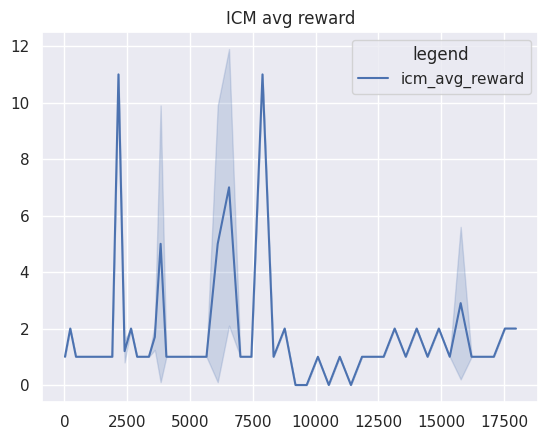

In [25]:


# https://stackoverflow.com/questions/61368805/how-to-plot-shaded-error-bands-with-seaborn

plt.plot(icm_cum_eps, icm_chkpt_mean_rewards, 'b-', label='icm_avg_reward')
plt.fill_between(icm_cum_eps, (icm_chkpt_mean_rewards - icm_chkpt_std_rewards), (icm_chkpt_mean_rewards + icm_chkpt_std_rewards), color='b', alpha=0.2) 

plt.legend(title='legend')
plt.title("ICM avg reward") 
plt.show()



## ICM avg steps

/usr/local/lib/python3.7/dist-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


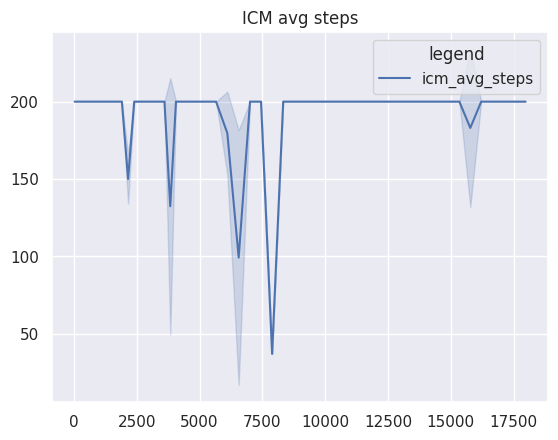

In [26]:


# https://stackoverflow.com/questions/61368805/how-to-plot-shaded-error-bands-with-seaborn

plt.plot(icm_cum_eps, icm_chkpt_mean_steps, 'b-', label='icm_avg_steps')
plt.fill_between(icm_cum_eps, (icm_chkpt_mean_steps - icm_chkpt_std_steps), (icm_chkpt_mean_steps + icm_chkpt_std_steps), color='b', alpha=0.2) 

plt.legend(title='legend')
plt.title("ICM avg steps") 
plt.show()



## ICM Path

In [54]:
#max_mean_rewards_idx = np.argmax(icm_chkpt_mean_rewards)
max_mean_rewards_idx = np.argmin(icm_chkpt_mean_steps)

eps_itr = icm_cum_eps[max_mean_rewards_idx]
print(eps_itr)
best_chkpt = icm_df[~(icm_df["eps_cumsum"].where(icm_df['eps_cumsum'] == eps_itr)).isna()]['checkpoint'].values[0]
print("Best checkpoint: ", best_chkpt)

7888.0
Best checkpoint:  340


In [57]:
chkpt_root = "/content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/sparse" 
chkpt_dir = "checkpoint_000" + str(best_chkpt)
chkpt_pth = chkpt_root + "/" + chkpt_dir
chkpt_pth

'/content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/sparse/checkpoint_000340'

In [58]:
icm_agent.restore(chkpt_pth)

2022-09-27 14:00:56,138	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/sparse/checkpoint_000340
2022-09-27 14:00:56,140	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 340, '_timesteps_total': None, '_time_total': 21612.675816059113, '_episodes_total': 7888}


cumulative reward 11.0
total steps: 36
Config file path: /content/drive/MyDrive/GitHub/INM363-Project/scenarios/custom/very_dense_reward.cfg
Scenario path: /content/drive/MyDrive/GitHub/INM363-Project/scenarios/custom/train/new_sparse_rs.wad
Health Bonus locations: [(-544.0, 96.0), (-544.0, 352.0), (-800.0, 96.0)]
Armor location: [(-544.0, -160.0)]
Sector locations: [(-640.0, -704.0, 32.0, 32.0), (-704.0, -640.0, 160.0, 160.0), (-608.0, -608.0, 192.0, 256.0), (-480.0, -480.0, 256.0, 192.0), (-640.0, -640.0, -256.0, -64.0), (-448.0, -640.0, -256.0, -256.0), (-448.0, -448.0, -64.0, -256.0), (-640.0, -608.0, -64.0, -64.0), (-480.0, -448.0, -64.0, -64.0), (-640.0, -640.0, 0.0, 32.0), (-448.0, -480.0, 0.0, 0.0), (-640.0, -640.0, 160.0, 192.0), (-608.0, -640.0, 0.0, 0.0), (-448.0, -448.0, 192.0, 0.0), (-640.0, -608.0, 192.0, 192.0), (-480.0, -448.0, 192.0, 192.0), (-480.0, -480.0, 0.0, -64.0), (-608.0, -608.0, -64.0, 0.0), (-448.0, -480.0, 256.0, 256.0), (-448.0, -448.0, 448.0, 256.0), (-640

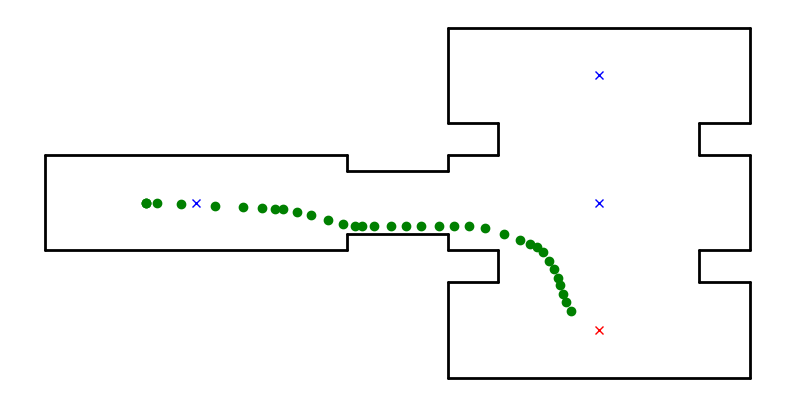

In [59]:
state = env.reset()
sum_reward = 0
n_step = 200
icm_path = [] 

for step in range(n_step):
    action = icm_agent.compute_action(state)
    state, reward, done, info = env.step(action)
    sum_reward += reward
    
    if len(info) > 0:
      icm_path.append((info["X"], info["Y"]))

    #env.render()

    if done == 1:
        # report at the end of each episode
        print("cumulative reward", sum_reward)
        print(f"total steps: {step}")
        state = env.reset()
        sum_reward = 0
        break

if done == 0:
  print("cumulative reward", sum_reward)
  print(f"total steps: {step}")

sectors, health_pos, armor_pos = helper.get_env_layout(config = "custom/very_dense_reward.cfg",
                                                       scenario = "custom/train/new_sparse_rs.wad" )
helper.plot_layout(sectors, health_pos, armor_pos, icm_path)


## ICM Goal Accomplishment

In [60]:
state = env.reset()

#ppo_path = [] 
num_episodes = 100 
goal_reached = 0 

for i in range(num_episodes):
    state = env.reset()
    eps_reward = 0
    n_step = 200

    for step in range(n_step):
        action = icm_agent.compute_action(state)
        state, reward, done, info = env.step(action)
        eps_reward += reward
      
        if done == 1:
          break 

    if eps_reward >= 10:
        goal_reached += 1
      
    

print(f"Number of time goal reached: {goal_reached} / {num_episodes}")


Number of time goal reached: 100 / 100


# RE3

In [32]:
class RE3Callbacks(RE3UpdateCallbacks, config["callbacks"]):
  pass

In [35]:
# configure the environment and create agent
config = ppo.DEFAULT_CONFIG.copy()
config["log_level"] = "WARN"
config["model"] = {"dim": 42, 
                   "grayscale": True,
                   }
config["num_gpus"] = 1
config["preprocessor_pref"] = "rllib"
config['explore'] = False 
config['in_evaluation'] = True
config["framework"] = "tf"
config["seed"] = 12345
config["callbacks"] = RE3Callbacks
config["exploration_config"] = {
    "type": "RE3",
     "embeds_dim": 128,
     "rho": 0.1, # Beta decay factor, used for on-policy algorithm.
     "k_nn": 7, # Number of neighbours to set for K-NN entropy estimation.
     "encoder_net_config": {
         "fcnet_hiddens": [],
         "fcnet_activation": "relu",
     },
     # `reward = r + beta * intrinsic_reward`
     "beta": 0.2,
     # Schedule to use for beta decay, one of constant" or "linear_decay".
     "beta_schedule": 'constant',
     # Specify, which exploration sub-type to use (usually, the algo's "default"
     # exploration, e.g. EpsilonGreedy for DQN, StochasticSampling for PG/SAC).
     "sub_exploration": {
         "type": "StochasticSampling",
     }
}
re3_agent = ppo.PPOTrainer(config, env=select_env)
print("created agent")

(RolloutWorker pid=14664) config file: /content/drive/MyDrive/GitHub/INM363-Project/scenarios/custom/very_dense_reward.cfg
(RolloutWorker pid=14664) scenario file: /content/drive/MyDrive/GitHub/INM363-Project/scenarios/custom/test/new_sparse_reward_fixed_start.wad
(RolloutWorker pid=14664) episode timeout: 800
(RolloutWorker pid=14664) screen resolution: 320X240
(RolloutWorker pid=14665) config file: /content/drive/MyDrive/GitHub/INM363-Project/scenarios/custom/very_dense_reward.cfg
(RolloutWorker pid=14665) scenario file: /content/drive/MyDrive/GitHub/INM363-Project/scenarios/custom/test/new_sparse_reward_fixed_start.wad
(RolloutWorker pid=14665) episode timeout: 800
(RolloutWorker pid=14665) screen resolution: 320X240


(RolloutWorker pid=14664) 2022-09-27 13:51:45,762	WARNING env.py:143 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.
(RolloutWorker pid=14664) /usr/local/lib/python3.7/dist-packages/gym/core.py:173: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed) instead.
(RolloutWorker pid=14664)   "Function `env.seed(seed)` is marked as deprecated and will be removed in the future. "
(RolloutWorker pid=14665) /usr/local/lib/python3.7/dist-packages/gym/core.py:173: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed) instead.
(RolloutWorker pid=14665)   "Function `env.seed(seed)` is marked as deprecated and will be remove

created agent


In [36]:
env = gym.make('VizDoomVeryDenseReward-v0')

config file: /content/drive/MyDrive/GitHub/INM363-Project/scenarios/custom/very_dense_reward.cfg
scenario file: /content/drive/MyDrive/GitHub/INM363-Project/scenarios/custom/test/new_sparse_reward_fixed_start.wad
episode timeout: 800
screen resolution: 320X240


In [37]:

chkpt_root = "/content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/sparse" 

pattern = '*checkpoint*'
checkpoints = [x for x in os.listdir(chkpt_root) if fnmatch(x,pattern )]


print("Total number of checkpoints: ", len(checkpoints))


re3_chkpt_mean_rewards = np.array([]) 
re3_chkpt_std_rewards = np.array([]) 
re3_chkpt_mean_steps = np.array([]) 
re3_chkpt_std_steps = np.array([]) 


for chkpt_dir in checkpoints:
  chkpt_pth = chkpt_root + '/' + chkpt_dir 
  print(chkpt_dir)
  re3_agent.restore(chkpt_pth)

  num_episodes = 10
  total_reward = []
  total_steps = [] 
  #chkpt_mean_reward = 0 

  for i in range(num_episodes):
    state = env.reset()
    eps_reward = 0
    eps_steps = 0 
    n_step = 200

    for step in range(n_step):
          action = re3_agent.compute_action(state)
          state, reward, done, info = env.step(action)
          eps_reward += reward

          #if episode ends early
          if done == 1:
              total_reward.append(eps_reward)
              total_steps.append(step+1)
              state = env.reset()
              break

    #if episode timeout
    if done == 0:
      total_reward.append(eps_reward)
      total_steps.append(n_step)

  #get mean and std over all episodes
  re3_chkpt_mean_rewards = np.append(re3_chkpt_mean_rewards, np.mean(total_reward) )
  re3_chkpt_std_rewards = np.append(re3_chkpt_std_rewards, np.std(total_reward))
  re3_chkpt_mean_steps = np.append(re3_chkpt_mean_steps, np.mean(total_steps))
  re3_chkpt_std_steps = np.append(re3_chkpt_std_steps, np.std(total_steps))



Total number of checkpoints:  36
checkpoint_000001


2022-09-27 13:52:03,360	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/sparse/checkpoint_000001
2022-09-27 13:52:03,368	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 1, '_timesteps_total': None, '_time_total': 59.07217836380005, '_episodes_total': 21}
2022-09-27 13:52:11,870	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/sparse/checkpoint_000010
2022-09-27 13:52:11,877	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 10, '_timesteps_total': None, '_time_total': 534.9720995426178, '_episodes_total': 238}


checkpoint_000010


2022-09-27 13:52:22,661	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/sparse/checkpoint_000020
2022-09-27 13:52:22,663	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 20, '_timesteps_total': None, '_time_total': 1061.0097987651825, '_episodes_total': 466}


checkpoint_000020


2022-09-27 13:52:32,226	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/sparse/checkpoint_000030
2022-09-27 13:52:32,234	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 30, '_timesteps_total': None, '_time_total': 1589.3130543231964, '_episodes_total': 703}


checkpoint_000030


2022-09-27 13:52:40,481	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/sparse/checkpoint_000040
2022-09-27 13:52:40,482	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 40, '_timesteps_total': None, '_time_total': 2115.9859886169434, '_episodes_total': 931}


checkpoint_000040


2022-09-27 13:52:48,219	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/sparse/checkpoint_000050
2022-09-27 13:52:48,221	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 50, '_timesteps_total': None, '_time_total': 2639.5114121437073, '_episodes_total': 1167}


checkpoint_000050


2022-09-27 13:52:54,653	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/sparse/checkpoint_000060
2022-09-27 13:52:54,656	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 60, '_timesteps_total': None, '_time_total': 3162.0341680049896, '_episodes_total': 1407}


checkpoint_000060


2022-09-27 13:53:03,156	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/sparse/checkpoint_000070
2022-09-27 13:53:03,158	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 70, '_timesteps_total': None, '_time_total': 3688.084823846817, '_episodes_total': 1643}


checkpoint_000070


2022-09-27 13:53:11,245	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/sparse/checkpoint_000080
2022-09-27 13:53:11,248	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 80, '_timesteps_total': None, '_time_total': 4213.586189031601, '_episodes_total': 1879}


checkpoint_000080


2022-09-27 13:53:19,411	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/sparse/checkpoint_000090
2022-09-27 13:53:19,413	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 90, '_timesteps_total': None, '_time_total': 4734.723187685013, '_episodes_total': 2121}


checkpoint_000090


2022-09-27 13:53:27,675	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/sparse/checkpoint_000100
2022-09-27 13:53:27,678	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 100, '_timesteps_total': None, '_time_total': 5258.125777006149, '_episodes_total': 2366}


checkpoint_000100


2022-09-27 13:53:30,355	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/sparse/checkpoint_000110
2022-09-27 13:53:30,358	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 110, '_timesteps_total': None, '_time_total': 5780.055105924606, '_episodes_total': 2622}


checkpoint_000110


2022-09-27 13:53:38,481	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/sparse/checkpoint_000120
2022-09-27 13:53:38,486	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 120, '_timesteps_total': None, '_time_total': 6309.644705057144, '_episodes_total': 2868}


checkpoint_000120


2022-09-27 13:53:46,534	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/sparse/checkpoint_000130
2022-09-27 13:53:46,536	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 130, '_timesteps_total': None, '_time_total': 6846.561623811722, '_episodes_total': 3119}


checkpoint_000130


2022-09-27 13:53:54,755	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/sparse/checkpoint_000140
2022-09-27 13:53:54,756	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 140, '_timesteps_total': None, '_time_total': 7378.410821437836, '_episodes_total': 3370}


checkpoint_000140


2022-09-27 13:54:02,845	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/sparse/checkpoint_000150
2022-09-27 13:54:02,849	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 150, '_timesteps_total': None, '_time_total': 7912.999238729477, '_episodes_total': 3643}


checkpoint_000150


2022-09-27 13:54:10,972	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/sparse/checkpoint_000160
2022-09-27 13:54:10,975	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 160, '_timesteps_total': None, '_time_total': 8451.893983364105, '_episodes_total': 3909}


checkpoint_000160


2022-09-27 13:54:14,059	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/sparse/checkpoint_000170
2022-09-27 13:54:14,060	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 170, '_timesteps_total': None, '_time_total': 8985.544698238373, '_episodes_total': 4185}


checkpoint_000170


2022-09-27 13:54:22,125	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/sparse/checkpoint_000180
2022-09-27 13:54:22,128	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 180, '_timesteps_total': None, '_time_total': 9515.946017026901, '_episodes_total': 4461}


checkpoint_000180


2022-09-27 13:54:30,283	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/sparse/checkpoint_000190
2022-09-27 13:54:30,294	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 190, '_timesteps_total': None, '_time_total': 10040.189677715302, '_episodes_total': 4749}


checkpoint_000190


2022-09-27 13:54:38,280	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/sparse/checkpoint_000200
2022-09-27 13:54:38,282	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 200, '_timesteps_total': None, '_time_total': 10563.784615755081, '_episodes_total': 5037}


checkpoint_000200


2022-09-27 13:54:46,320	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/sparse/checkpoint_000220
2022-09-27 13:54:46,331	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 220, '_timesteps_total': None, '_time_total': 11778.501620054245, '_episodes_total': 5617}


checkpoint_000220


2022-09-27 13:54:47,833	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/sparse/checkpoint_000240
2022-09-27 13:54:47,843	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 240, '_timesteps_total': None, '_time_total': 12992.191339731216, '_episodes_total': 6195}


checkpoint_000240


2022-09-27 13:54:49,654	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/sparse/checkpoint_000260
2022-09-27 13:54:49,656	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 260, '_timesteps_total': None, '_time_total': 14207.60643863678, '_episodes_total': 6793}


checkpoint_000260


2022-09-27 13:54:53,383	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/sparse/checkpoint_000280
2022-09-27 13:54:53,395	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 280, '_timesteps_total': None, '_time_total': 15407.628764152527, '_episodes_total': 7394}


checkpoint_000280


2022-09-27 13:54:55,885	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/sparse/checkpoint_000300
2022-09-27 13:54:55,887	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 300, '_timesteps_total': None, '_time_total': 16598.916384220123, '_episodes_total': 7988}


checkpoint_000300


2022-09-27 13:54:57,398	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/sparse/checkpoint_000320
2022-09-27 13:54:57,400	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 320, '_timesteps_total': None, '_time_total': 17789.758455991745, '_episodes_total': 8593}


checkpoint_000320


2022-09-27 13:54:58,998	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/sparse/checkpoint_000340
2022-09-27 13:54:59,000	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 340, '_timesteps_total': None, '_time_total': 18976.287672758102, '_episodes_total': 9215}


checkpoint_000340


2022-09-27 13:55:06,638	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/sparse/checkpoint_000360
2022-09-27 13:55:06,640	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 360, '_timesteps_total': None, '_time_total': 20145.02285051346, '_episodes_total': 9889}


checkpoint_000360


2022-09-27 13:55:08,450	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/sparse/checkpoint_000380
2022-09-27 13:55:08,452	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 380, '_timesteps_total': None, '_time_total': 21316.552579402924, '_episodes_total': 10533}


checkpoint_000380


2022-09-27 13:55:16,689	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/sparse/checkpoint_000400
2022-09-27 13:55:16,693	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 400, '_timesteps_total': None, '_time_total': 22501.329653024673, '_episodes_total': 11316}


checkpoint_000400


2022-09-27 13:55:18,206	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/sparse/checkpoint_000420
2022-09-27 13:55:18,207	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 420, '_timesteps_total': None, '_time_total': 23741.530092716217, '_episodes_total': 12477}


checkpoint_000420


2022-09-27 13:55:19,966	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/sparse/checkpoint_000440
2022-09-27 13:55:19,972	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 440, '_timesteps_total': None, '_time_total': 24944.106615781784, '_episodes_total': 13926}


checkpoint_000440


2022-09-27 13:55:21,510	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/sparse/checkpoint_000460
2022-09-27 13:55:21,520	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 460, '_timesteps_total': None, '_time_total': 26198.637117147446, '_episodes_total': 15504}


checkpoint_000460


2022-09-27 13:55:22,952	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/sparse/checkpoint_000480
2022-09-27 13:55:22,955	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 480, '_timesteps_total': None, '_time_total': 27374.89703798294, '_episodes_total': 17093}


checkpoint_000480


2022-09-27 13:55:24,343	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/sparse/checkpoint_000500
2022-09-27 13:55:24,348	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 500, '_timesteps_total': None, '_time_total': 28550.41579556465, '_episodes_total': 18765}


checkpoint_000500


In [38]:
#read first results file 
results_pth = chkpt_root + '/' + 'result.csv'
re3_df_1 = pd.read_csv(results_pth) 
re3_df = re3_df_1

#cumulative sum of episodes
re3_df['eps_cumsum'] = re3_df['episodes_this_iter'].cumsum()
re3_df = re3_df[['checkpoint', 'eps_cumsum']]
re3_df.checkpoint = re3_df['checkpoint'].astype(int)
re3_df.tail()

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,checkpoint,eps_cumsum
495,496,18436.0
496,497,18523.0
497,498,18604.0
498,499,18686.0
499,500,18765.0


In [39]:
re3_cum_eps = [] 
for chkpt in checkpoints:
  chkpt_int = int(chkpt.split('_')[-1])
  eps_num = re3_df[~(re3_df['eps_cumsum'].where(re3_df['checkpoint'] == chkpt_int)).isna()].eps_cumsum.values[0]
  re3_cum_eps.append(eps_num)

print(f"Total episodes: {re3_cum_eps}")
print(f"Mean reward: {re3_chkpt_mean_rewards}")
print(f"Std reward: {re3_chkpt_std_rewards}")
print(f"Mean steps: {re3_chkpt_mean_steps}")
print(f"Std steps: {re3_chkpt_std_steps}")

#check length of lists are the same 
assert len(re3_cum_eps) == len(re3_chkpt_mean_rewards)
assert len(re3_cum_eps) == len(re3_chkpt_mean_steps)

Total episodes: [21.0, 238.0, 466.0, 703.0, 931.0, 1167.0, 1407.0, 1643.0, 1879.0, 2121.0, 2366.0, 2622.0, 2868.0, 3119.0, 3370.0, 3643.0, 3909.0, 4185.0, 4461.0, 4749.0, 5037.0, 5617.0, 6195.0, 6793.0, 7394.0, 7988.0, 8593.0, 9215.0, 9889.0, 10533.0, 11316.0, 12477.0, 13926.0, 15504.0, 17093.0, 18765.0]
Mean reward: [ 0.   0.   0.   0.   2.4  5.   0.   2.   2.   2.  12.   2.   3.   2.
  2.4  3.  12.   2.   1.8  3.   2.  11.  12.   9.  12.  11.  11.   4.
 11.   1.  11.  12.  11.  11.  11.  11. ]
Std reward: [0.         0.         0.         0.         3.23109888 4.58257569
 0.         0.         0.         0.         0.         0.
 0.         0.         0.48989795 0.         0.         0.
 0.4        0.         0.         0.         0.         4.58257569
 0.         0.         0.         4.         0.         0.
 0.         0.         0.         0.         0.         0.        ]
Mean steps: [200.  200.  200.  200.  187.4 158.9 200.  200.  200.  200.   60.  200.
 200.  200.  200.  200. 

## RE3 avg reward

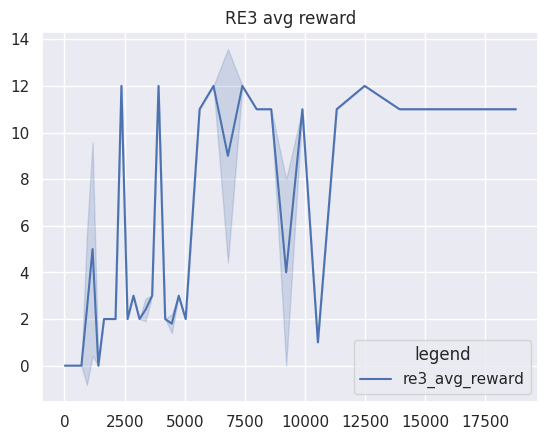

In [40]:
# https://stackoverflow.com/questions/61368805/how-to-plot-shaded-error-bands-with-seaborn

plt.plot(re3_cum_eps, re3_chkpt_mean_rewards, 'b-', label='re3_avg_reward')
plt.fill_between(re3_cum_eps, (re3_chkpt_mean_rewards - re3_chkpt_std_rewards), (re3_chkpt_mean_rewards + re3_chkpt_std_rewards), color='b', alpha=0.2) 

plt.legend(title='legend')
plt.title("RE3 avg reward") 
plt.show()



## RE3 avg steps

/usr/local/lib/python3.7/dist-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


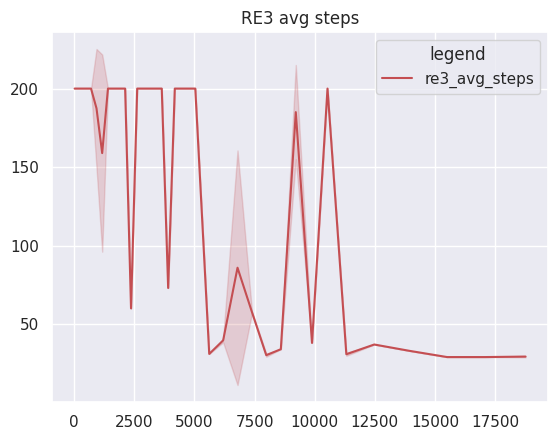

In [41]:


# https://stackoverflow.com/questions/61368805/how-to-plot-shaded-error-bands-with-seaborn

plt.plot(re3_cum_eps, re3_chkpt_mean_steps, 'r-', label='re3_avg_steps')
plt.fill_between(re3_cum_eps, (re3_chkpt_mean_steps - re3_chkpt_std_steps), (re3_chkpt_mean_steps + re3_chkpt_std_steps), color='r', alpha=0.2) 

plt.legend(title='legend')
plt.title("RE3 avg steps") 
plt.show()



## RE3 Path

In [61]:
#max_mean_rewards_idx = np.argmax(re3_chkpt_mean_rewards)
max_mean_rewards_idx = np.argmin(re3_chkpt_mean_steps)
eps_itr = re3_cum_eps[max_mean_rewards_idx]
print(eps_itr)
best_chkpt = re3_df[~(re3_df["eps_cumsum"].where(re3_df['eps_cumsum'] == eps_itr)).isna()]['checkpoint'].values[-1]
print("Best checkpoint: ", best_chkpt)

15504.0
Best checkpoint:  460


In [62]:
chkpt_root = "/content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/sparse" 
chkpt_dir = "checkpoint_000" + str(best_chkpt)
chkpt_pth = chkpt_root + "/" + chkpt_dir
chkpt_pth

'/content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/sparse/checkpoint_000460'

In [63]:
re3_agent.restore(chkpt_pth)

2022-09-27 14:01:40,267	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/sparse/checkpoint_000460
2022-09-27 14:01:40,276	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 460, '_timesteps_total': None, '_time_total': 26198.637117147446, '_episodes_total': 15504}


cumulative reward 11.0
total steps: 28
Config file path: /content/drive/MyDrive/GitHub/INM363-Project/scenarios/custom/very_dense_reward.cfg
Scenario path: /content/drive/MyDrive/GitHub/INM363-Project/scenarios/custom/train/new_sparse_rs.wad
Health Bonus locations: [(-544.0, 96.0), (-544.0, 352.0), (-800.0, 96.0)]
Armor location: [(-544.0, -160.0)]
Sector locations: [(-640.0, -704.0, 32.0, 32.0), (-704.0, -640.0, 160.0, 160.0), (-608.0, -608.0, 192.0, 256.0), (-480.0, -480.0, 256.0, 192.0), (-640.0, -640.0, -256.0, -64.0), (-448.0, -640.0, -256.0, -256.0), (-448.0, -448.0, -64.0, -256.0), (-640.0, -608.0, -64.0, -64.0), (-480.0, -448.0, -64.0, -64.0), (-640.0, -640.0, 0.0, 32.0), (-448.0, -480.0, 0.0, 0.0), (-640.0, -640.0, 160.0, 192.0), (-608.0, -640.0, 0.0, 0.0), (-448.0, -448.0, 192.0, 0.0), (-640.0, -608.0, 192.0, 192.0), (-480.0, -448.0, 192.0, 192.0), (-480.0, -480.0, 0.0, -64.0), (-608.0, -608.0, -64.0, 0.0), (-448.0, -480.0, 256.0, 256.0), (-448.0, -448.0, 448.0, 256.0), (-640

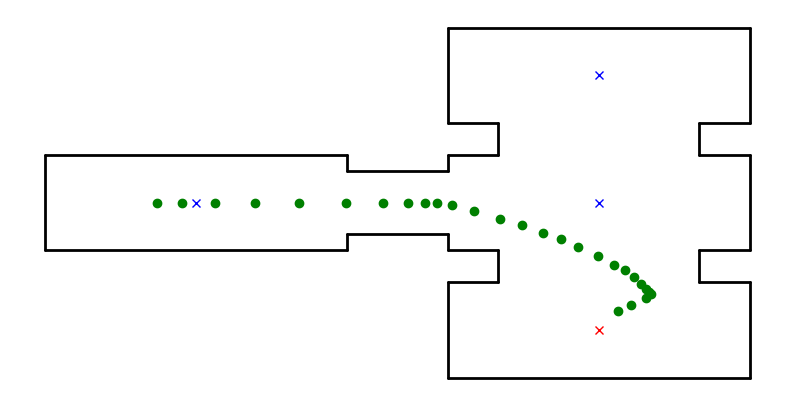

In [64]:
state = env.reset()
sum_reward = 0
n_step = 200
re3_path = [] 

for step in range(n_step):
    action = re3_agent.compute_action(state)
    state, reward, done, info = env.step(action)
    sum_reward += reward
    
    if len(info) > 0:
      re3_path.append((info["X"], info["Y"]))

    #env.render()

    if done == 1:
        # report at the end of each episode
        print("cumulative reward", sum_reward)
        print(f"total steps: {step}")
        state = env.reset()
        sum_reward = 0
        break

if done == 0:
  print("cumulative reward", sum_reward)
  print(f"total steps: {step}")


sectors, health_pos, armor_pos = helper.get_env_layout(config = "custom/very_dense_reward.cfg",
                                                       scenario = "custom/train/new_sparse_rs.wad" )
helper.plot_layout(sectors, health_pos, armor_pos, re3_path)


## RE3 Goal Accomplishment

In [65]:
state = env.reset()

#ppo_path = [] 
num_episodes = 100 
goal_reached = 0 

for i in range(num_episodes):
    state = env.reset()
    eps_reward = 0
    n_step = 200

    for step in range(n_step):
        action = re3_agent.compute_action(state)
        state, reward, done, info = env.step(action)
        eps_reward += reward
      
        if done == 1:
          break 

    if eps_reward >= 10:
        goal_reached += 1
      
    

print(f"Number of time goal reached: {goal_reached} / {num_episodes}")


Number of time goal reached: 100 / 100


# All graphs

## Plot all paths

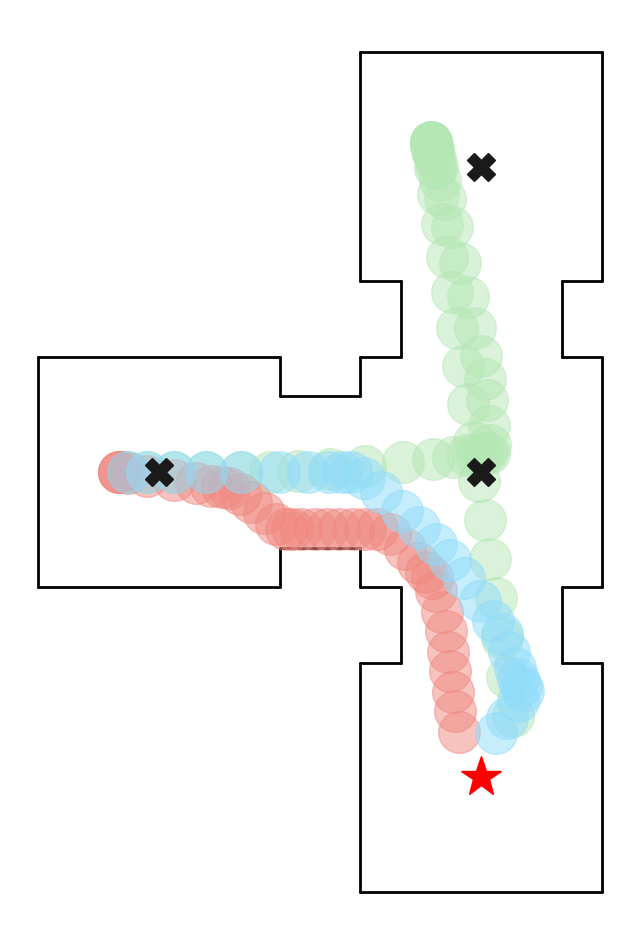

In [72]:
plt.rcParams["figure.figsize"] = (8, 12)

for sector in sectors:
        plt.plot([sector[0], sector[1]], [sector[2], sector[3]], color='black', linewidth=2)

# plot path taken
for pos in ppo_path:
    plt.plot(pos[0], pos[1], color='#B5E7B5', marker='o', markersize = 30, alpha = 0.5)
for pos in icm_path:
    plt.plot(pos[0], pos[1], color='#F08880', marker='o', markersize = 30, alpha = 0.5)
for pos in re3_path:
    plt.plot(pos[0], pos[1], color='#8FDCFB', marker='o', markersize=30, alpha = 0.5)

#'#2E75B6'
    

# plot positions of health bonus and armor:
for pos in health_pos:
    plt.plot(pos[0], pos[1], color='k', marker='X', markersize = 20)
for pos in armor_pos:
    plt.plot(pos[0], pos[1], color='red', marker='*', markersize = 30)

plt.axis("off")
plt.show()


## Average Reward

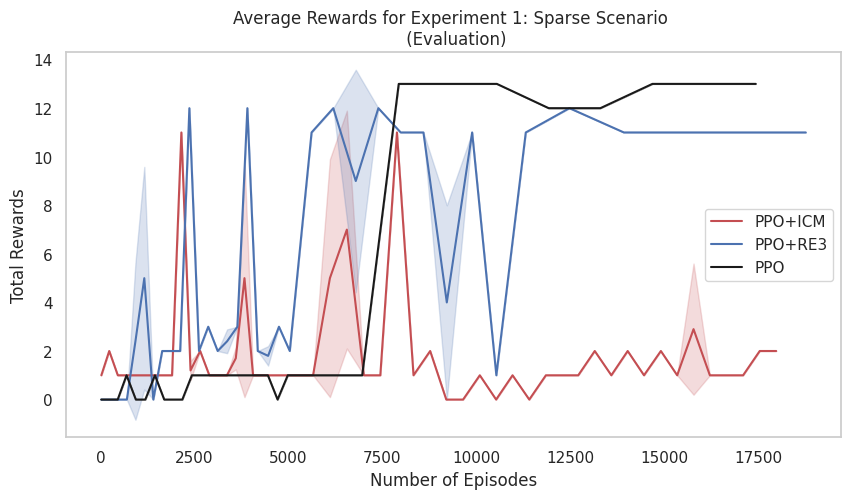

In [48]:
plt.rcParams["figure.figsize"] = (10,5)
sns.set_style("whitegrid", {'axes.grid' : False})


#ICM
plt.plot(icm_cum_eps, icm_chkpt_mean_rewards, 'r-', label='PPO+ICM')
plt.fill_between(icm_cum_eps, (icm_chkpt_mean_rewards - icm_chkpt_std_rewards), (icm_chkpt_mean_rewards + icm_chkpt_std_rewards), color='r', alpha=0.2) 
#RE3
plt.plot(re3_cum_eps, re3_chkpt_mean_rewards, 'b-', label='PPO+RE3')
plt.fill_between(re3_cum_eps, (re3_chkpt_mean_rewards - re3_chkpt_std_rewards), (re3_chkpt_mean_rewards + re3_chkpt_std_rewards), color='b', alpha=0.2) 
#PPO 
plt.plot(ppo_cum_eps[:-9], ppo_chkpt_mean_rewards[:-9], 'k-', label='PPO')
plt.fill_between(ppo_cum_eps[:-9], (ppo_chkpt_mean_rewards - ppo_chkpt_std_rewards)[:-9], (ppo_chkpt_mean_rewards + ppo_chkpt_std_rewards)[:-9], color='k', alpha=0.2) 


plt.legend()
plt.title("Average Rewards for Experiment 1: Sparse Scenario \n (Evaluation)") 
plt.xlabel('Number of Episodes') 
plt.ylabel('Total Rewards') 
plt.show()


## Average Steps

/usr/local/lib/python3.7/dist-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


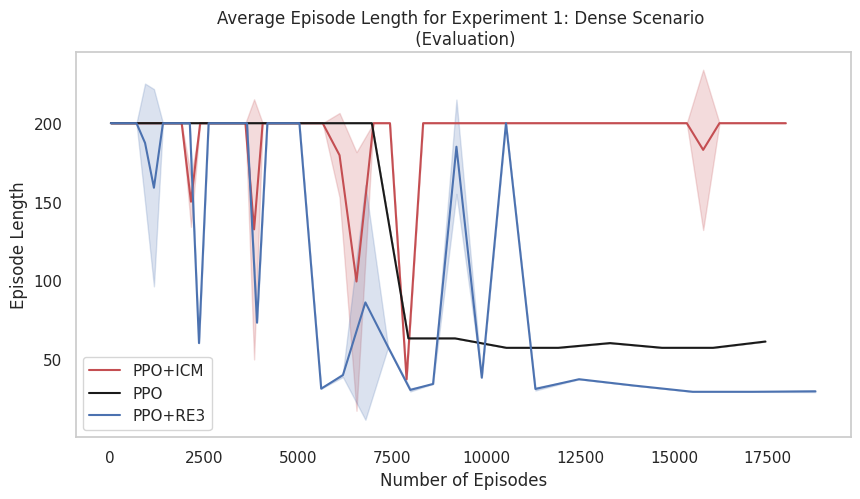

In [49]:
plt.rcParams["figure.figsize"] = (10,5)
sns.set_style("whitegrid", {'axes.grid' : False})



#ICM
plt.plot(icm_cum_eps, icm_chkpt_mean_steps, 'r-', label='PPO+ICM')
plt.fill_between(icm_cum_eps, (icm_chkpt_mean_steps - icm_chkpt_std_steps), (icm_chkpt_mean_steps + icm_chkpt_std_steps), color='r', alpha=0.2) 

#PPO
plt.plot(ppo_cum_eps[:-9], ppo_chkpt_mean_steps[:-9], 'k-', label='PPO')
plt.fill_between(ppo_cum_eps[:-9], (ppo_chkpt_mean_steps - ppo_chkpt_std_steps)[:-9], (ppo_chkpt_mean_steps + ppo_chkpt_std_steps)[:-9], color='k', alpha=0.2) 

#RE3
plt.plot(re3_cum_eps, re3_chkpt_mean_steps, 'b-', label='PPO+RE3')
plt.fill_between(re3_cum_eps, (re3_chkpt_mean_steps - re3_chkpt_std_steps), (re3_chkpt_mean_steps + re3_chkpt_std_steps), color='b', alpha=0.2) 

plt.legend()
plt.title("Average Episode Length for Experiment 1: Dense Scenario \n (Evaluation)") 
plt.xlabel('Number of Episodes') 
plt.ylabel('Episode Length') 
plt.show()

# Save results file

In [50]:
from pathlib import Path 
root = "/content/drive/MyDrive/GitHub/INM363-Project/results" 
cols = ["episodes", "mean_reward", "std_reward", "mean_steps", "std_steps"]


/usr/local/lib/python3.7/dist-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## PPO

In [51]:
fname = "/E1b_ppo_sparse.csv"

df_ppo = pd.DataFrame(columns = cols)
df_ppo["episodes"] = ppo_cum_eps
df_ppo["mean_reward"] = ppo_chkpt_mean_rewards
df_ppo["std_reward"] = ppo_chkpt_std_rewards
df_ppo["mean_steps"] = ppo_chkpt_mean_steps
df_ppo["std_steps"] = ppo_chkpt_std_steps

fpath = Path(root + fname)
df_ppo.to_csv(fpath)
print(f"Saved results file to {fpath.as_posix()}")

df_ppo.head()

Saved results file to /content/drive/MyDrive/GitHub/INM363-Project/results/E1b_ppo_sparse.csv


,episodes,mean_reward,std_reward,mean_steps,std_steps
0,21.0,0.0,0.0,200.0,0.0
1,228.0,0.0,0.0,200.0,0.0
2,459.0,0.0,0.0,200.0,0.0
3,695.0,1.0,0.0,200.0,0.0
4,942.0,0.0,0.0,200.0,0.0


## ICM

In [52]:
fname = "/E1b_icm_sparse.csv"

df_icm = pd.DataFrame(columns = cols)
df_icm["episodes"] = icm_cum_eps
df_icm["mean_reward"] = icm_chkpt_mean_rewards
df_icm["std_reward"] = icm_chkpt_std_rewards
df_icm["mean_steps"] = icm_chkpt_mean_steps
df_icm["std_steps"] = icm_chkpt_std_steps

fpath = Path(root + fname)
df_icm.to_csv(fpath)
print(f"Saved results file to {fpath.as_posix()}")

df_icm.head()

Saved results file to /content/drive/MyDrive/GitHub/INM363-Project/results/E1b_icm_sparse.csv


/usr/local/lib/python3.7/dist-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,episodes,mean_reward,std_reward,mean_steps,std_steps
0,24.0,1.0,0.0,200.0,0.0
1,234.0,2.0,0.0,200.0,0.0
2,462.0,1.0,0.0,200.0,0.0
3,692.0,1.0,0.0,200.0,0.0
4,936.0,1.0,0.0,200.0,0.0


## RE3

In [53]:
fname = "/E1b_re3_sparse.csv"

df_re3 = pd.DataFrame(columns = cols)
df_re3["episodes"] = re3_cum_eps
df_re3["mean_reward"] = re3_chkpt_mean_rewards
df_re3["std_reward"] = re3_chkpt_std_rewards
df_re3["mean_steps"] = re3_chkpt_mean_steps
df_re3["std_steps"] = re3_chkpt_std_steps

fpath = Path(root + fname)
df_re3.to_csv(fpath)
print(f"Saved results file to {fpath.as_posix()}")

df_re3.head()

Saved results file to /content/drive/MyDrive/GitHub/INM363-Project/results/E1b_re3_sparse.csv


/usr/local/lib/python3.7/dist-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,episodes,mean_reward,std_reward,mean_steps,std_steps
0,21.0,0.0,0.000000,200.0,0.0
1,238.0,0.0,0.000000,200.0,0.0
2,466.0,0.0,0.000000,200.0,0.0
3,703.0,0.0,0.000000,200.0,0.0
4,931.0,2.4,3.231099,187.4,37.8
